# Bolus Tracking

Use this notebook for single animals, otherwise run it in batch from **GLUT1_Analysis**

In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import MRIhelperfunctions as h
import MRIhelperfunctions
from MRIhelperfunctions import Settings
from imp import importlib
import fnmatch
import papermill as pm

import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline  

from lmfit.models import ExpressionModel

In [144]:
importlib.reload(h)
import MRIhelperfunctions as h
from MRIhelperfunctions import Settings

In [2]:
# Default Parameters (to run script independently)
folders = {}
folders['raw'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata'
folders['main'] = os.path.dirname(folders['raw'])
folders['analysis'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Analysis'
folders['animal'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/20180604_101508_Glut1_2_2'
folders['excel'] = 'Animal_Scan_IDs.xlsx'


animal = 'glut1_male1'


info = h.getinfo(folders)
info

,glut1_male1,glut1_male2,glut1_f10wks1,glut1_f10wks2,glut1_f10wks3,glut1_f10wks4,glut1_f10wks5,glut1_f10wks6,glut1_f8wks1,glut1_f8wks2,glut1_f8wks3,glut1_f8wks4,glut1_f8wks5,glut1_f8wks6,glut1_f8wks7,glut1_f6wks2,glut1_f6wks1
scan,,,,,,,,,,,,,,,,,
genotype,1,1,1,2,1,2,2,1,1,1,2,2,2,2,1,1,1
Gd DCE,6,8,6,5,5,8,5,5,7,5,6,6,8,8,6,5,5
Angio pre,8,9,7,6,6,9,6,6,8,6,9,8,9,9,8,6,6
Angio post,12,12,11,9,9,13,10,11,12,11,12,12,16,13,12,9,10
Endorem DCE,11,11,10,8,8,12,9,10,10,10,11,11,15,12,11,8,9
Diamox,15,14,13,11,13,15,12,13,15,13,16,17,20,16,14,11,13
folder,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...


In [52]:
# additional Script specific parameters

try:
    info = pd.read_json(info)  #<-- dont run this line in single animal mode
except:
    pass

folders['template'] = os.path.join(folders['main'], 'Templates', 'BolusTracking.nii') # from animal glut1_male1
folders['in'] = os.path.join(folders['analysis'], animal)
folders['out'] = os.path.join(folders['in'], 'BolusTracking')


baseline = 400  # points before certainly don't contain bolus pass yet



if not os.path.exists(folders['out']):
    os.makedirs(folders['out'] )

In [10]:
scans={}
scans['number'] = int(info.loc['Endorem DCE', animal])

scans['raw'] = os.path.join(folders['in'], f"X{scans['number']}P1.nii")


raw = nib.load(scans['raw'])
print(f'check if these dimensions make sense: {raw.shape}')

check if these dimensions make sense: (80, 35, 10, 1200)


## Coregistration 
No motion correction

In [11]:
# cut out a single repetition
scans['single'] = f"{folders['out']}/single_timepoint.nii"
h.runAFNI(f"3dTcat -prefix {scans['single']} {scans['raw']}'[0]'")

# cut off first 10 points
scans['cut'] = os.path.join(folders['out'], f"{scans['number']}_cut.nii")
h.runAFNI(f"3dTcat -prefix {scans['cut']} {scans['raw']}'[10..$]'")

# coregistration
scans['single_coreg'], scans['coreg'] = h.simple_coreg(folders['template'], scans['single'], scans['cut'], folders['out'])

3dTcat -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/BolusTracking/single_timepoint.nii /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/X11P1.nii'[0]'
3dTcat -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/BolusTracking/11_cut.nii /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/X11P1.nii'[10..$]'
3dAllineate -base /home/aic/BigHDD/MR_DATA/GLUT1/Templates/BolusTracking.nii -source /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/BolusTracking/single_timepoint.nii -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/BolusTracking/A_coreg.nii -cost ls -zclip -interp quintic -final wsinc5 -twopass -twoblur 2 -fineblur 0.5 -nmatch 80% -conv 0.01 -1Dparam_save /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/BolusTracking/1dparams.1D
3dAllineate -1Dparam_apply /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/BolusTracking/1dparams.1D -source /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/BolusTracking/11_cut.nii -prefix /home/aic/BigHDD/

## Data Preparations 

In [12]:
# scans['coreg'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/BolusTracking/B_coreg.nii'


img = nib.load(scans['coreg'])
data = img.get_fdata()
hdr = img.header
print(hdr)


dimensions = Settings()
dimensions.t_res = hdr['pixdim'][4]

dimensions.x = hdr['dim'][1]
dimensions.y = hdr['dim'][2]
dimensions.z = hdr['dim'][3]

dimensions.affine=np.zeros((4,4))
dimensions.affine[0,:] = hdr['srow_x']
dimensions.affine[1,:] = hdr['srow_y']
dimensions.affine[2,:] = hdr['srow_z']

data_reshaped = data.reshape(-1, data.shape[-1]) # we keep the 1190 time points, but put flatten all voxels in 1D.

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 48
dim             : [   4   80   35   10 1190    1    1    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.         0.2        0.2        0.50591666 0.4        0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 9
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.70710677
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -8.455814
qoffset_y       :

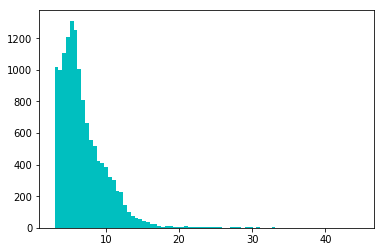

In [49]:
# threshold here determines how fast analysis runs, voxels with signal lower than threshold are set to zero.

data_averaged = np.mean(data,axis=3)  # average time points

threshold = 3

plt.hist(data_averaged.flatten(), bins=80, color='c', range=(threshold, np.max(data)))
plt.show()

# for voxel in data_reshaped:
#         if np.mean(voxel) > threshold:
#             x=voxel

voxelnr = 80*35*7 + 80*6+18
x=data_reshaped[voxelnr,420:450]
# x=data_reshaped[voxelnr]


plt.figure(figsize=(20,10))
plt.plot(x)
plt.plot(np.diff(x))
# plt.plot(y,'o')
# plt.plot(x[0:],'o')
plt.show()

## Defining important functions

# V2: convert to concentration

def preparesignal(raw_input):
        
    min_point = np.argmin(raw_input)
    
    # sanity check: if signal is just noise, minimum could be anywhere and ruin fit
    # ensure that minimum is within reasonable range, otherwise just return an empty array
    if ( min_point < 10 or min_point > (raw_input.size - 100) ): 
        return np.zeros_like(raw_input), np.zeros_like(raw_input), 0
    
    start_point = min_point - 5    
    
    # end_point in words: first point after the absolute minimum that reaches 90% of post-injection baseline (first 100 points) level
    end_point = int(np.argwhere(raw_input[min_point:] >= 0.9 * np.mean(raw_input[min_point+8:min_point+100]))[0]) + min_point

    # continue with concentration  - K * ln( S(t) / S(0) )  (we ignore K)
    c = -np.log(raw_input / np.mean(raw_input[:start_point-2]))
    CBV_steady = np.mean(c[end_point+2:end_point+200]) / np.mean(c[:start_point-2])
    # another sanity check, only in noise voxels can be negative values
    if CBV_steady <= 0: 
        return np.zeros_like(raw_input), np.zeros_like(raw_input), 0
    
    bsl = np.mean(c[:start_point-2])
    c[end_point+1:] = bsl
#     raw_input = raw_input-bsl
#     x = x/np.max(np.abs(x))
#     c[end_point:end_point+5]=0

    weights=np.ones_like(c)
    weights[end_point:end_point+5]=0

    output = c[start_point-5:end_point+15]
    weights = weights[start_point-5:end_point+15]
    
    return output, weights, CBV_steady

In [103]:
# V3: Choosing the start and end points to cut out from signal. Ensure only first pass is taken

def preparesignal(raw_input):
    
    skip = False
    
    
    if np.mean(raw_input) < threshold:
        return 0, 0, 0, True
        
    min_point = np.argmin(raw_input)
    # sanity check: if signal is just noise, minimum could be anywhere and ruin fit
    # ensure that minimum is within reasonable range, otherwise just return an empty array
    if ( min_point < baseline or min_point > (baseline + 50) ): 
        return 0, 0, 0, True
    
    # start point in words:  ~2s before bolus peak. = 5 data points at 400ms TR.
    start_point = min_point - np.int(2/dimensions.t_res)   
    
    # end_point: for simplicity here just 4 data points after minimum. TODO: find point where diff(signal) does no longer increase monotonically (i.e. 2nd pass incoming)
    end_point = min_point + np.int(1.7/dimensions.t_res)
    
    # continue with concentration  - K * ln( S(t) / S(0) )  (we ignore K)
    c = -np.log(raw_input / np.mean(raw_input[:start_point-2]))
    
    # CBV0 determined from 'steady state' value (is not really staying constant, so we just use first 200 points)
    CBV_steady = np.mean(c[end_point+2:end_point+200]) / np.mean(c[:start_point-2])
    # another sanity check, only in noise voxels CBV can be a negative value
    if CBV_steady <= 0: 
        return 0, 0, 0, True
    
    bsl = np.mean(c[:start_point-2])
    c[end_point+1:] = bsl
    
    # don't consider the abrupt jump to baseline in the fit (due to removal of 2nd pass points), ignore 2.5s
    weights=np.ones_like(c)
    weights[end_point:end_point+ np.int(2.5/dimensions.t_res) ] = 0

    output = c[start_point-5:end_point+15]
    weights = weights[start_point-5:end_point+15]
    
    return output, weights, CBV_steady, skip

In [104]:
script = """
def gammavar(ymax, tmax, a, x, t0):
    x_input = x * (x > t0) + (t0 + tmax) * (x <= t0)
    return (exp(log(ymax)+a*(1+log((x_input-t0)/tmax)-(x_input-t0)/tmax))) * (x > t0)
"""


def run_fit(x):
    """
    Does a couple of things:
    1. prepare the gamma variate fit model, define starting values and boundaries.
    2. runs the function preparesignal() that (among other processing) cuts out the area around the bolus to speed up fitting.
    3. runs the fit and calculates some parameters of the gamma variate
    """
    
    model = ExpressionModel(f'gammavar(ymax0, tmax0, a0, x, t0)',
                    init_script=script,
                    intependent_vars=['x'], nan_policy='propagate')

    params = model.make_params()
    params['ymax0'].set(value=0.5, min=0, max=20)
    params['tmax0'].set(value=2, min=1, max=10)
    params['a0'].set(2, min=0.1, max=5)
    params['t0'].set(value=2.1, min=1, max=4)
    
    curves ={}
    curves['signal'], curves['weights'], cbv_steady, skip = preparesignal(x)
    if skip:
        return 0, 0, 0, 0
    
    curves['time'] = np.arange(0,curves['signal'].size)*dimensions.t_res

    if np.sum(curves['signal']) > 0:
        
        curves['result'] = model.fit(curves['signal'], params, x=curves['time'], weights=curves['weights'])
        
        a = curves['result'].best_fit
        
        mean = a[np.nonzero(a)].mean() # only of the nonzero curve values!
        integral = np.sum(a)
        #         firstmoment = np.sum( curves['result'].best_fit * curves['time'] ) # not sure where I got that
        
    else:
        integral = 0
        mean = 0
        curves['result'] = 0
   
    return integral, mean, curves, cbv_steady



## Debugging -  Looking at single voxels:  processing & fit

# Debugging 1: turn raw signal into corrected concentration time-curve

mrslice=80*35*5
voxelonslice = 80*12+18
x = data_reshaped[mrslice+voxelonslice,:]

y, weights, CBV_steady, skip = preparesignal(x)

plt.figure()
plt.plot(x)  # raw signal of that voxel


# Debugging 2: running fit and showing results for a single voxel

try:
    integral, maximum, curves, cbv_steady = run_fit(data_reshaped[mrslice+voxelonslice,:])


    CBV_val = integral
    MTT_val = CBV_val / maximum
    CBF_val = CBV_val / MTT_val
    print(f'CBV (bolus): {CBV_val}')
    print(f'CBV (steady state): {cbv_steady}')
    print(f'MTT: {MTT_val}')
    print(f'CBF: {CBF_val}')
    print(curves['result'].fit_report())
    plt.figure(figsize=[20,10])
    plt.plot(curves['time'], curves['signal'])
    plt.plot(curves['time'], curves['result'].best_fit)
    plt.plot(curves['time'], curves['weights'],'x')
    
except:
    print('bad voxel')

## Run the fit over the whole brain

May take long time!

In [107]:
n_voxel = data_reshaped.shape[0]
integral = np.zeros(n_voxel)
mean = np.zeros(n_voxel)
cbv_steady = np.zeros(n_voxel)
raw_bolus = np.zeros((n_voxel,20))
fit_bolus = np.zeros((n_voxel,20))

for voxel in range(n_voxel):
    integral[voxel], mean[voxel], curves, cbv_steady[voxel] = run_fit(data_reshaped[voxel,:])
    
    # code below is just to create intermediate output (maps with bolus and fit curve to check quality of fit)
    
    try:
        n = curves['signal'].size
        if n > 20:
            n = 20
        raw_bolus[voxel,:n] =  curves['signal'][:n]
    except:
        pass
    
    try:
        fit_bolus[voxel,:n] =  curves['result'].best_fit[:n]
    except:
        pass
    
    if voxel % 300 == 0:
        percent = (voxel+0.01) / n_voxel * 100
        print(f"{percent:.2f} % done")

0.00 % done
1.07 % done
2.14 % done
3.21 % done
4.29 % done
5.36 % done
6.43 % done
7.50 % done
8.57 % done
9.64 % done
10.71 % done
11.79 % done
12.86 % done
13.93 % done
15.00 % done
16.07 % done
17.14 % done
18.21 % done
19.29 % done
20.36 % done
21.43 % done
22.50 % done
23.57 % done
24.64 % done
25.71 % done
26.79 % done
27.86 % done
28.93 % done
30.00 % done
31.07 % done
32.14 % done
33.21 % done
34.29 % done
35.36 % done
36.43 % done
37.50 % done
38.57 % done
39.64 % done
40.71 % done
41.79 % done
42.86 % done
43.93 % done
45.00 % done
46.07 % done
47.14 % done
48.21 % done
49.29 % done
50.36 % done
51.43 % done
52.50 % done
53.57 % done
54.64 % done
55.71 % done
56.79 % done
57.86 % done
58.93 % done
60.00 % done
61.07 % done
62.14 % done
63.21 % done
64.29 % done
65.36 % done
66.43 % done
67.50 % done
68.57 % done
69.64 % done
70.71 % done
71.79 % done
72.86 % done
73.93 % done
75.00 % done
76.07 % done
77.14 % done
78.21 % done
79.29 % done
80.36 % done
81.43 % done
82.50 % d

### Notes for viewing the output files

By default, AFNI will open the .nii files created here in Talairach space (+tlrc), which cannot be viewed together with +orig files, causing problems.

**Simple solution**: in your home directory, add this line to the *.afnirc*   (e.g. /home/aic/.afnirc) file:

    AFNI_NIFTI_VIEW = orig


Now, all .nii files are opened in +orig original format. Which means every file can be used as underlay / overlay etc. with every other file.

## Store the results

In [108]:
# calculate parameter maps from fit

# for formulas see: https://onlinelibrary.wiley.com/doi/full/10.1002/1522-2586%28200009%2912%3A3%3C400%3A%3AAID-JMRI5%3E3.0.CO%3B2-C
CBV_map = integral
MTT_map = mean / integral
CBF_map = CBV_map / MTT_map

# save Nifti Files
scans={}

# files to check fit quality, are not used in group results
scans['raw_bolus'] = h.save_nifti(raw_bolus, dimensions, folders, animal, 'raw_bolus_timecourse')
scans['fit_bolus'] = h.save_nifti(fit_bolus, dimensions, folders, animal, 'fit_bolus_timecourse')

# outputs to be used in group analysis
scans['CBV_steady'] = h.save_nifti(cbv_steady, dimensions, folders, animal, 'CBV_steadystate_map')
scans['CBV_bolus'] = h.save_nifti(CBV_map, dimensions, folders, animal, 'CBV_bolus_map')
scans['MTT'] = h.save_nifti(MTT_map, dimensions, folders, animal, 'MTT_map')
scans['CBF'] = h.save_nifti(CBF_map, dimensions, folders, animal, 'CBF_map')

# save directories with papermill for the main notebook:
pm.record("CBV_steady", scans['CBV_steady'])
pm.record("CBV_bolus", scans['CBV_bolus'])
pm.record("MTT", scans['MTT'])
pm.record("CBF", scans['CBF'])

/home/aic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
